# ECOSTRESS Soil Moisture Visualization

Trực quan hóa dữ liệu độ ẩm đất ECOSTRESS cho tất cả các ngày có sẵn.

**Dữ liệu**: ECOSTRESS Gridded Downscaled Soil Moisture (70m) - Tháng 6/2023

In [1]:
# Import các thư viện cần thiết
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import glob
import os
import warnings
from matplotlib.patches import Rectangle
from matplotlib.collections import LineCollection
warnings.filterwarnings('ignore')

# Thiết lập matplotlib
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 12

print("✅ Đã import thành công tất cả thư viện!")

✅ Đã import thành công tất cả thư viện!


In [2]:
# Đường dẫn đến dữ liệu
data_dir = "/Users/ninhhaidang/Library/CloudStorage/GoogleDrive-ninhhailongg@gmail.com/My Drive/Cac_mon_hoc/Do_an_tot_nghiep/25-26_HKI_DATN_21021411_DangNH/Data/ECOSTRESS Gridded Downscaled Soil Moisture Instantaneous L3 Global 70 m V002/"
shapefile_dir = "/Users/ninhhaidang/Library/CloudStorage/GoogleDrive-ninhhailongg@gmail.com/My Drive/Cac_mon_hoc/Do_an_tot_nghiep/25-26_HKI_DATN_21021411_DangNH/Data/Shapefile/"

# Lấy danh sách file ECOSTRESS
h5_files = glob.glob(os.path.join(data_dir, "*.h5"))
h5_files.sort()

print(f"📁 Tìm thấy {len(h5_files)} file ECOSTRESS:")
for i, file in enumerate(h5_files):
    filename = os.path.basename(file)
    date_str = filename.split('_')[5][:8]
    date_formatted = f"{date_str[:4]}-{date_str[4:6]}-{date_str[6:8]}"
    print(f"  {i+1}. {date_formatted}")

# Đọc shapefile Hòa Lạc
hoa_lac_shp = os.path.join(shapefile_dir, "hoa_lac.shp")
if os.path.exists(hoa_lac_shp):
    hoa_lac_boundary = gpd.read_file(hoa_lac_shp)
    print(f"\n🗺️  Đã đọc thành công shapefile Hòa Lạc")
    print(f"   - CRS: {hoa_lac_boundary.crs}")
    print(f"   - Số polygon: {len(hoa_lac_boundary)}")
else:
    print(f"\n⚠️  Không tìm thấy shapefile: {hoa_lac_shp}")
    hoa_lac_boundary = None

📁 Tìm thấy 4 file ECOSTRESS:
  1. 2023-06-01
  2. 2023-06-02
  3. 2023-06-05
  4. 2023-06-12

🗺️  Đã đọc thành công shapefile Hòa Lạc
   - CRS: EPSG:4326
   - Số polygon: 1


In [3]:
def read_ecostress_simple(file_path):
    """Đọc dữ liệu ECOSTRESS cần thiết"""
    data = {}
    
    with h5py.File(file_path, 'r') as f:
        # Đọc dữ liệu chính
        data['SM'] = f['/HDFEOS/GRIDS/ECO_L3G_SM_70m/Data Fields/SM'][:]
        
        # Đọc thông tin địa lý
        std_meta = f['/HDFEOS/ADDITIONAL/FILE_ATTRIBUTES/StandardMetadata']
        data['bounds'] = {
            'north': float(std_meta['NorthBoundingCoordinate'][()]),
            'south': float(std_meta['SouthBoundingCoordinate'][()]),
            'east': float(std_meta['EastBoundingCoordinate'][()]),
            'west': float(std_meta['WestBoundingCoordinate'][()])
        }
        
        data['date'] = std_meta['RangeBeginningDate'][()].decode('utf-8')
        
    return data

def create_coordinate_arrays(bounds, shape):
    """Tạo mảng tọa độ từ bounds và shape"""
    rows, cols = shape
    
    # Tạo mảng longitude và latitude
    lon = np.linspace(bounds['west'], bounds['east'], cols)
    lat = np.linspace(bounds['north'], bounds['south'], rows)  # North to South
    
    return lon, lat

📅 Tạo visualization tất cả các ngày có sẵn...
✓ Đã đọc: 2023-06-01
✓ Đã đọc: 2023-06-01
✓ Đã đọc: 2023-06-02
✓ Đã đọc: 2023-06-02
✓ Đã đọc: 2023-06-05
✓ Đã đọc: 2023-06-05
✓ Đã đọc: 2023-06-12
✓ Đã đọc: 2023-06-12


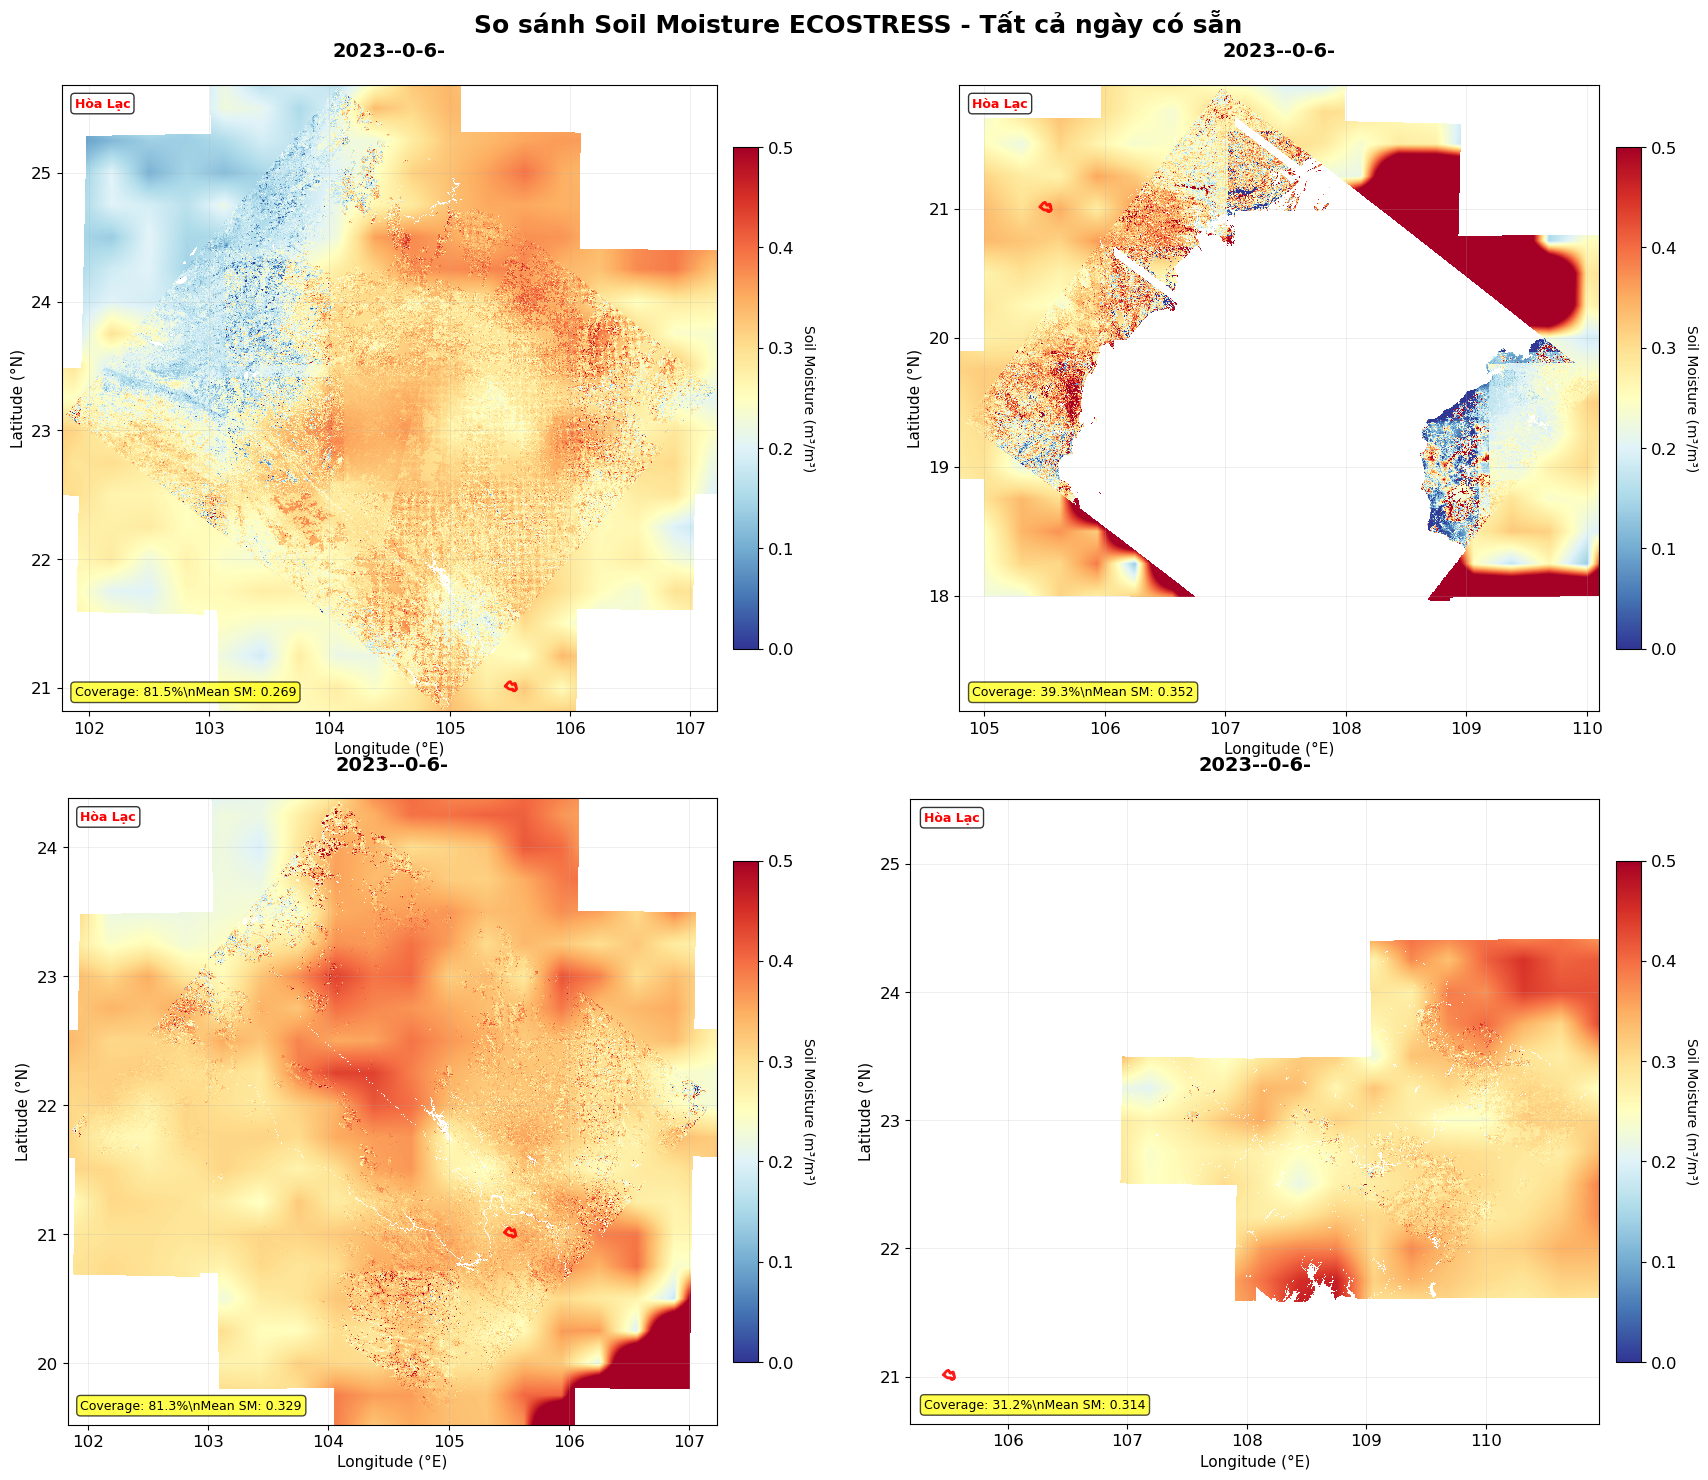

\n✅ Đã hiển thị 4 ảnh ECOSTRESS
\n📊 TÓNG QUAN THEO NGÀY:
--------------------------------------------------
2023--0-6-: Coverage  81.5% | Mean SM 0.269
2023--0-6-: Coverage  81.5% | Mean SM 0.269
2023--0-6-: Coverage  39.3% | Mean SM 0.352
2023--0-6-: Coverage  39.3% | Mean SM 0.352
2023--0-6-: Coverage  81.3% | Mean SM 0.329
2023--0-6-: Coverage  81.3% | Mean SM 0.329
2023--0-6-: Coverage  31.2% | Mean SM 0.314
--------------------------------------------------
2023--0-6-: Coverage  31.2% | Mean SM 0.314
--------------------------------------------------
🔍 Coverage trung bình: 58.3%
⚠️  Chất lượng dữ liệu TRUNG BÌNH
🔍 Coverage trung bình: 58.3%
⚠️  Chất lượng dữ liệu TRUNG BÌNH


In [4]:
# Tạo 2x2 subplots với SM (tất cả các ảnh của các ngày)
print("📅 Tạo visualization tất cả các ngày có sẵn...")

# Đọc tất cả các file
all_data = []
dates = []

for file_path in h5_files:
    try:
        data = read_ecostress_simple(file_path)
        all_data.append(data)
        dates.append(data['date'])
        print(f"✓ Đã đọc: {data['date']}")
    except Exception as e:
        print(f"❌ Lỗi đọc file {os.path.basename(file_path)}: {e}")

if len(all_data) >= 1:
    # Tạo figure với 2x2 layout cho 4 ảnh
    fig, axes = plt.subplots(2, 2, figsize=(18, 15))
    fig.suptitle('So sánh Soil Moisture ECOSTRESS - Tất cả ngày có sẵn', fontsize=18, fontweight='bold')
    
    # Flatten axes array để dễ truy cập
    axes_flat = axes.flatten()
    
    for i, (data, date) in enumerate(zip(all_data, dates)):
        if i >= 4:  # Chỉ hiển thị tối đa 4 ảnh
            break
            
        ax = axes_flat[i]
        
        # Chuẩn bị dữ liệu
        sm_display = np.copy(data['SM'])
        sm_display[sm_display < 0] = np.nan
        sm_display[sm_display > 1] = np.nan
        
        # Tạo tọa độ
        lon, lat = create_coordinate_arrays(data['bounds'], data['SM'].shape)
        lon_grid, lat_grid = np.meshgrid(lon, lat)
        
        # Plot soil moisture
        im = ax.pcolormesh(lon_grid, lat_grid, sm_display, cmap='RdYlBu_r', 
                          shading='auto', vmin=0, vmax=0.5)
        
        # Format ngày hiển thị
        date_formatted = f"{date[:4]}-{date[4:6]}-{date[6:8]}"
        ax.set_title(f'{date_formatted}', fontsize=14, fontweight='bold', pad=20)
        ax.set_xlabel('Longitude (°E)', fontsize=11)
        ax.set_ylabel('Latitude (°N)', fontsize=11)
        
        # Thêm ranh giới Hòa Lạc
        if hoa_lac_boundary is not None:
            try:
                # Đảm bảo CRS là WGS84
                if hoa_lac_boundary.crs != 'EPSG:4326':
                    boundary_wgs84 = hoa_lac_boundary.to_crs('EPSG:4326')
                else:
                    boundary_wgs84 = hoa_lac_boundary
                
                boundary_wgs84.boundary.plot(ax=ax, color='red', linewidth=2, alpha=0.9)
                
                # Thêm label cho ranh giới
                ax.text(0.02, 0.98, 'Hòa Lạc', transform=ax.transAxes, 
                       verticalalignment='top', 
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                       fontsize=9, color='red', fontweight='bold')
            except Exception as e:
                print(f"Không thể vẽ boundary cho {date}: {e}")
        
        # Colorbar
        cbar = plt.colorbar(im, ax=ax, shrink=0.8, pad=0.02)
        cbar.set_label('Soil Moisture (m³/m³)', rotation=270, labelpad=15, fontsize=10)
        
        # Grid
        ax.grid(True, alpha=0.3, linewidth=0.5)
        
        # Thống kê coverage
        valid_count = np.sum(~np.isnan(sm_display))
        total_count = sm_display.size
        coverage = valid_count / total_count * 100
        
        # Hiển thị thống kê
        if valid_count > 0:
            mean_sm = np.nanmean(sm_display)
            stats_text = f'Coverage: {coverage:.1f}%\\nMean SM: {mean_sm:.3f}'
        else:
            stats_text = f'Coverage: {coverage:.1f}%\\nNo valid data'
            
        ax.text(0.02, 0.02, stats_text, transform=ax.transAxes, 
               bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7),
               fontsize=9, verticalalignment='bottom')
    
    # Ẩn subplot trống nếu có ít hơn 4 ảnh
    for i in range(len(all_data), 4):
        axes_flat[i].set_visible(False)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)  # Điều chỉnh để có chỗ cho title
    plt.show()
    
    # Tóm tắt thống kê
    print(f"\\n✅ Đã hiển thị {len(all_data)} ảnh ECOSTRESS")
    print("\\n📊 TÓNG QUAN THEO NGÀY:")
    print("-" * 50)
    
    for i, (data, date) in enumerate(zip(all_data, dates)):
        sm_display = np.copy(data['SM'])
        sm_display[sm_display < 0] = np.nan
        sm_display[sm_display > 1] = np.nan
        
        valid_count = np.sum(~np.isnan(sm_display))
        coverage = valid_count / sm_display.size * 100
        
        date_formatted = f"{date[:4]}-{date[4:6]}-{date[6:8]}"
        
        if valid_count > 0:
            mean_sm = np.nanmean(sm_display)
            print(f"{date_formatted}: Coverage {coverage:5.1f}% | Mean SM {mean_sm:.3f}")
        else:
            print(f"{date_formatted}: Coverage {coverage:5.1f}% | No valid data")
    
    print("-" * 50)
    
    # Tính coverage trung bình
    coverages = []
    for data in all_data:
        sm = np.copy(data['SM'])
        sm[sm < 0] = np.nan
        sm[sm > 1] = np.nan
        valid_count = np.sum(~np.isnan(sm))
        coverage = valid_count / sm.size * 100
        coverages.append(coverage)
    
    avg_coverage = np.mean(coverages)
    print(f"🔍 Coverage trung bình: {avg_coverage:.1f}%")
    
    if avg_coverage > 60:
        print("✅ Chất lượng dữ liệu TỐT")
    elif avg_coverage > 40:
        print("⚠️  Chất lượng dữ liệu TRUNG BÌNH")
    else:
        print("❌ Chất lượng dữ liệu THẤP")
        
else:
    print("❌ Không có dữ liệu để hiển thị")